In [3]:
import numpy as np
import cv2
import pyrealsense2 as rs
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
import warnings
import json
import pickle
import random
from keras.models import model_from_json, load_model

warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

In [4]:
def cv2pil(image):
    ''' OpenCV型 -> PIL型 '''
    new_image = image.copy()
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = new_image[:, :, ::-1]
    elif new_image.shape[2] == 4:  # 透過
        new_image = new_image[:, :, [2, 1, 0, 3]]
    new_image = Image.fromarray(new_image)
    return new_image

In [5]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [6]:
def detect_contour(image):
    obj_list = []
    #src = cv2.imread(path, cv2.IMREAD_COLOR)
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    retval, bw = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    contours, hierarchy = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    detect_count = 0

    for i in range(0, len(contours)):
        area = cv2.contourArea(contours[i])
        
        if area < 1e4 or 1e5 < area:
            continue
            
        if len(contours[i]) > 0:
            rect = contours[i]
            x, y, w, h = cv2.boundingRect(rect)
            
            angle_data = cv2.minAreaRect(contours[i])
            angle = angle_data[2]
            if angle < -8 and angle > -82:
                pass
            else:
                angle = 0
            point = [y, y+h, x, x+w, angle]
            obj_list.append(point)           
    return obj_list

def detect_contour_rotation(image):
    len_dict = {}
    #src = cv2.imread(path, cv2.IMREAD_COLOR)
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    retval, bw = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    contours, hierarchy = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    detect_count = 0

    for i in range(0, len(contours)):
        area = cv2.contourArea(contours[i])
        
        if area < 1e4 or 1e5 < area:
            continue
            
        if len(contours[i]) > 0:
            rect = contours[i]
            x, y, w, h = cv2.boundingRect(rect)
            w_h_len = w+h
            
            point = [y, y+h, x, x+w]
            len_dict[w_h_len] = point 
    if len_dict == {}:
        print('発見できませんでした.')
        return None
    return len_dict[max(len_dict)]
    
def excute_obj_v2(name):
    save_path = name+'.png'
    cv2.imwrite(save_path, image)
    obj_dict = detect_contour_v2(save_path)
    return obj_dict

In [7]:
def make_feature(depth_cut):
    data_list = []
    img = depth_cut
    area = img.shape[0]*img.shape[1]
    width = img.shape[1]
    height = img.shape[0]
    depth_sum = 0
    for col in img:
        for d in col:
            depth_sum += d
            data_list.append(d)
    depth_sum_area = depth_sum/area
    length = width+height
    depth_median = np.median(data_list)
    depth_mean = round(np.mean(data_list), 1)
    w_h = [width, height]
    ratio = max(w_h)/min(w_h)
    dataseries = {'area': area, 'depth_sum': depth_sum, 'depth_sum/area': depth_sum_area,
              'length': length, 'depth_median': depth_median, 'depth_mean': depth_mean, 'ratio': ratio}
    df_new = pd.DataFrame.from_dict(dataseries, orient='index').T
    test = df_new.values
    return test

def image_rotation(img, angle):
    height = img.shape[0]                         
    width = img.shape[1]                          
    center = (int(width/2), int(height/2))
    scale = 1.0
    trans = cv2.getRotationMatrix2D(center, angle , scale)
    img2 = cv2.warpAffine(img, trans, (width,height))
    return img2

In [8]:
before_dict = {'allegra_x': 0, 'allegra_y': 1, 'allegra_z':2 , 'amazon_x': 3, 'amazon_y': 4, 'amazon_z': 5, 'dog_x': 6,
               'dog_y': 7, 'dog_z': 8, 'iris_x': 9, 'iris_y': 10, 'iris_z': 11, 'mintia_x': 12, 'realsense_x': 13, 'realsense_y': 14,
               'realsense_z': 15, 'tepra_x': 16, 'tepra_y': 17, 'tepra_z': 18, 'whiteTape_x': 19, 'whiteTape_y':20, 'whiteTape_z': 21,
               'yellowTape_x': 22, 'yellowTape_y': 23, 'yellowTape_z': 24}
def find_one(pre, collect_dict):
    label = 100
    random_num = random.randint(0, 500)
    for i, number in enumerate(pre):
        if number == 1:
            label = i
    if label == 100:
        print('発見できませんでした.')
        key = 'none_' + str(random_num)
    else:
        key = [k for k, v in collect_dict.items() if v == label][0]
        print(key)
    return key

def find_neural(pre, collect_dict):
    index = np.argmax(pre)
    key = [k for k, v in collect_dict.items() if v == index][0]
    print(key)
    return key

In [9]:
result_dict = {}

In [10]:
config = rs.config()

config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

In [33]:
pipeline = rs.pipeline()
profile = pipeline.start(config)
align = rs.align(rs.stream.color)
count = 1
try:
    while True:

        frames = pipeline.wait_for_frames()
        aligned_frames = align.process(frames)
        
        color_frame = aligned_frames.get_color_frame()
        depth_frame = aligned_frames.get_depth_frame()
        if not depth_frame or not color_frame:
            continue
        
        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())

        count += 1
        if count == 10:
            break                     

finally:
    # ストリーミング停止
    pipeline.stop()

In [34]:
check = cv2pil(color_image)
check.show()

In [35]:
unique_dict = {}
image_list = []
depth_copy = copy.deepcopy(depth_image)
for col in depth_image:
    for one in col:
        if one > 1000:
            image_list.append(0)
        else:
            image_list.append(one)
        if one not in unique_dict:
            unique_dict[one] = 1
        else:
            unique_dict[one] +=1
img_list_zoom = []
for pixel in image_list:
    if pixel > 150 and pixel < 338:
        img_list_zoom.append(pixel)
        
for y, col in enumerate(depth_image):
    for x, pixel in enumerate(col):
        if pixel > 150 and pixel < 338: 
            depth_image[y][x] = 255
        else:
            depth_image[y][x] = 0
image = np.array(depth_image, dtype=np.uint8)

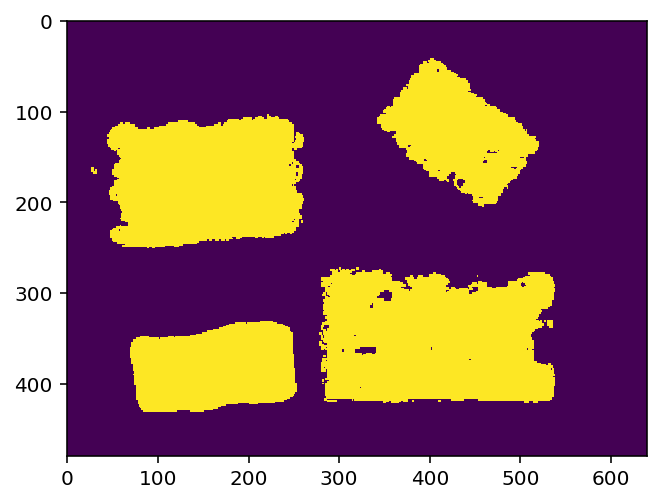

In [36]:
plt.imshow(image)

In [30]:
obj_list = detect_contour(image)
obj_list

[[334, 432, 70, 254, 0],
 [269, 422, 278, 538, 0],
 [105, 252, 45, 262, 0],
 [44, 204, 344, 522, -52.05784225463867]]

In [31]:
with open('random_forest/random_forest_model_v7.sav', mode='rb') as fp:
    random_forest = pickle.load(fp)

return_dict = {}
for point in obj_list:
    if point[4] == 0:
        depth_cut = depth_copy[point[0]:point[1], point[2]:point[3]]
        test = make_feature(depth_cut)
        predict = random_forest.predict(test)
        key = find_one(predict[0], before_dict)
        return_dict[key] = point
    else:
        data_list = []
        img = image[point[0]:point[1], point[2]:point[3]]
        depth_cut = depth_copy[point[0]:point[1], point[2]:point[3]]
        #depth_rotation = copy.deepcopy(depth_copy)
#         depth_sum = 0
#         for col in depth_cut:
#             for d in col:
#                 depth_sum += d
#                 data_list.append(d)
        
        r_img = image_rotation(img, point[4])
        depth_cut_rotation = image_rotation(depth_cut, point[4])
        new_point = detect_contour_rotation(r_img)
        if new_point == None:
            continue
        new_img = r_img[new_point[0]:new_point[1], new_point[2]:new_point[3]]
        new_depth_img = depth_cut_rotation[new_point[0]:new_point[1], new_point[2]:new_point[3]]
        depth_sum = 0
        for col in new_depth_img:
            for d in col:
                depth_sum += d
                data_list.append(d)
#         plt.imshow(new_depth_img), plt.show()
#         print(new_depth_img.shape)
        
        #plt.imshow(new_img)
        #plt.show()
        width = new_img.shape[1]
        height = new_img.shape[0]
        area = width*height
        depth_sum_area = depth_sum/area
        length = width+height
        depth_median = np.median(data_list)
        depth_mean = round(np.mean(data_list), 1)
        w_h = [width, height]
        ratio = max(w_h)/min(w_h)
        dataseries = {'area': area, 'depth_sum': depth_sum, 'depth_sum/area': depth_sum_area,
                  'length': length, 'depth_median': depth_median, 'depth_mean': depth_mean, 'ratio': ratio}
        df_new = pd.DataFrame.from_dict(dataseries, orient='index').T
        test = df_new.values
        predict = random_forest.predict(test)
        key = find_one(predict[0], before_dict)
        return_dict[key] = point

mintia_x
allegra_x
dog_x
yellowTape_y


mintia_x


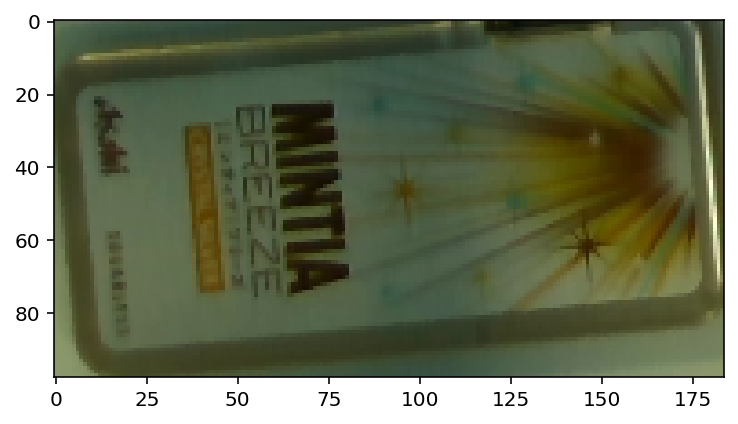

allegra_x


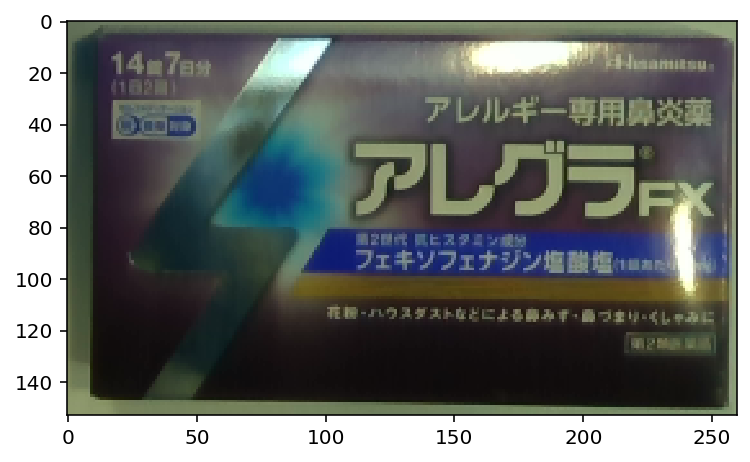

dog_x


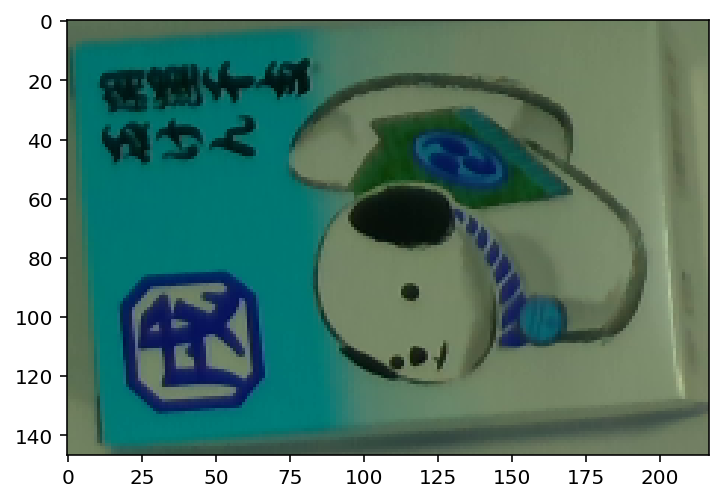

yellowTape_y


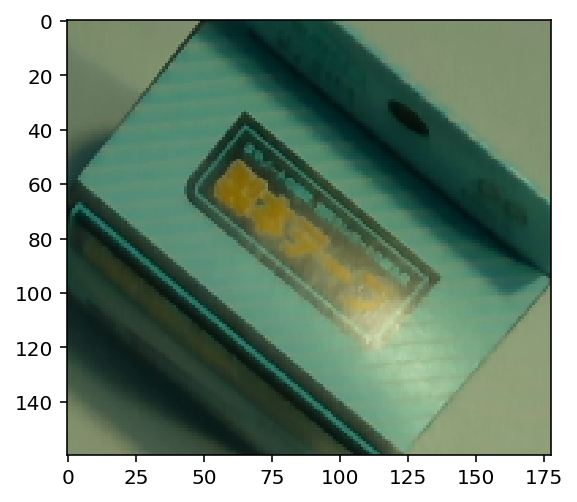

In [32]:
for key, value in return_dict.items():
    print(key)
    plt.imshow(color_image[value[0]:value[1], value[2]:value[3]])
    plt.show()

In [600]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_test = sc.fit_transform(test)

In [601]:
model = load_model('neuralnet_model_v4.h5')

return_dict = {}
for point in obj_list:
    if point[4] == 0:
        depth_cut = depth_copy[point[0]:point[1], point[2]:point[3]]
        test = make_feature(depth_cut)
        test = sc.fit_transform(test)
        predict = model.predict(test)
        key = find_neural(predict[0], before_dict)
        return_dict[key] = point
    else:
        data_list = []
        img = image[point[0]:point[1], point[2]:point[3]]
        depth_cut = depth_copy[point[0]:point[1], point[2]:point[3]]
        #depth_rotation = copy.deepcopy(depth_copy)
#         depth_sum = 0
#         for col in depth_cut:
#             for d in col:
#                 depth_sum += d
#                 data_list.append(d)
        
        r_img = image_rotation(img, point[4])
        depth_cut_rotation = image_rotation(depth_cut, point[4])
        new_point = detect_contour_rotation(r_img)
        new_img = r_img[new_point[0]:new_point[1], new_point[2]:new_point[3]]
        new_depth_img = depth_cut_rotation[new_point[0]:new_point[1], new_point[2]:new_point[3]]
        depth_sum = 0
        for col in new_depth_img:
            for d in col:
                depth_sum += d
                data_list.append(d)
#         plt.imshow(new_depth_img), plt.show()
#         print(new_depth_img.shape)
        
        #plt.imshow(new_img)
        #plt.show()
        width = new_img.shape[1]
        height = new_img.shape[0]
        area = width*height
        depth_sum_area = depth_sum/area
        length = width+height
        depth_median = np.median(data_list)
        depth_mean = round(np.mean(data_list), 1)
        w_h = [width, height]
        ratio = max(w_h)/min(w_h)
        dataseries = {'area': area, 'depth_sum': depth_sum, 'depth_sum/area': depth_sum_area,
                  'length': length, 'depth_median': depth_median, 'depth_mean': depth_mean, 'ratio': ratio}
        df_new = pd.DataFrame.from_dict(dataseries, orient='index').T
        test = df_new.values
        test = sc.fit_transform(test)
        predict = model.predict(test)
        key = find_neural(predict[0], before_dict)
        return_dict[key] = point

発見できませんでした.


TypeError: 'NoneType' object is not subscriptable

In [461]:
pred

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)